# Interpretable Machine Learning with Python
## **Exercise**: _Ensuring Machine Learning Fairness with Monotonic Constraints_
### Workshop for Machine Learning Prague — scheduled for October 30th, 2020 17:30 CET
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/), [Packt](https://www.packtpub.com/authors/serg-masis)) 

For reference, the presentation about this notebook is [found here](https://docs.google.com/presentation/d/1nFkXUK4wKHnrqaPNpdoTY4agGd2dROBm8gHU6QC6Lxs/edit?usp=sharing)

This notebook will walk through:

- Understanding how uneven distributions of features create the sparsity that produces uneven probabilities.
- Training a cost-sensitive [LightGBM](https://lightgbm.readthedocs.io/en/latest/) model that maximizes true-negatives.
- Leveraging **global interpretation methods** with [SHAP](https://github.com/slundberg/shap) to understand what features and feature values impact the model and how do they interact.
- Training a constrained LightGBM model **with fairness in mind**  with **monotonic and interaction constraints**.
- Verifying that the constrained LightGBM did indeed monotonically constrain some features and interaction constrain some feature groupings.
- Training a [Tensorflow Lattice](https://www.tensorflow.org/lattice/overview) model to monotonically constrain the same features as the constrained LightGBM one.
- Visualize with contour plots the outcome of the TF Lattice model.

For further understanding regarding the dataset :

- [Wightman, L. (1998). LSAC national longitudinal bar passage study. Law School Admission Council.](https://racism.org/images/pdf/LawSchool/Admission/NLBPS.pdf)

The dataset we will use has already been filtered to drop rows with where the features or label of interest are missing, and unnecessary columns removed. The original dataset can be  [found here](https://raw.githubusercontent.com/serenalwang/shape_constraints_for_ethics/master/lsac.csv).

## 1) Install Libraries
#### _(if not installed already)_

In [ ]:
!pip install --upgrade --quiet tensorflow-lattice seaborn

## 2) Load Libraries

In [1]:
#ESSENTIALS
import math
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import logging
logging.disable(sys.maxsize)

#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

#MODELING
import lightgbm as lgb
import tensorflow as tf
import tensorflow_lattice as tfl

#VISUALIZATION
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#INTERPRETATION
from sklearn import metrics
from matplotlib import cm
import matplotlib.ticker as plticker
import shap

## 3) Data Preparation & Understanding

### 3.1) Load Dataset

In [2]:
law_df = pd.read_csv('https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/law-bar-exam_mlprague.csv')
law_df.set_index(['ID'], inplace=True)

### 3.2) Prepare Dataset

We will subset the dataset:

In [3]:
target_col = 'pass_bar'
predict_cols = ['lsat', 'ugpa', 'DOB_yr', 'grad', 'fulltime', 'parttime', 'fam_inc']
exam_cols = ['lsat', 'ugpa']
law_df = law_df[[target_col] + predict_cols]

Verify that it was prepared correctly with `info()`:

In [4]:
law_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22823 entries, 2 to 27477
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pass_bar  22823 non-null  int64  
 1   lsat      22823 non-null  float64
 2   ugpa      22823 non-null  float64
 3   DOB_yr    22823 non-null  int64  
 4   grad      22823 non-null  int64  
 5   fulltime  22823 non-null  int64  
 6   parttime  22823 non-null  int64  
 7   fam_inc   22823 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.6 MB


Should have 22,823 records and 7 columns. None of the columns have nulls, and are all numerical.

### 3.3) Grades Distributions

Plot distribution of grade features:

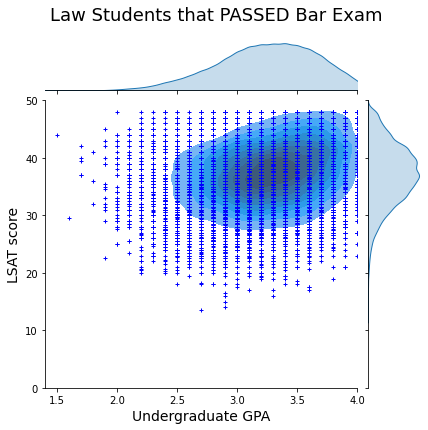

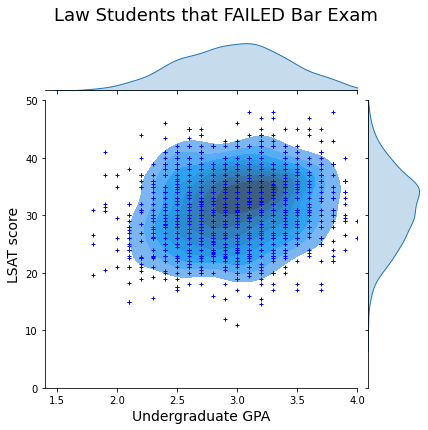

In [5]:
ax1 = sns.jointplot(x='ugpa', y='lsat', data=law_df[law_df[target_col] == 1],\
                   kind='kde', xlim=[1.4, 4], ylim=[0, 50], fill=True)
ax1.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
ax1.ax_joint.collections[0].set_alpha(0)
ax1.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
ax1.fig.suptitle('Law Students that PASSED Bar Exam', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

ax2 = sns.jointplot(x='ugpa', y='lsat', data=law_df[law_df[target_col] == 0],\
                   kind='kde', xlim=[1.4, 4], ylim=[0, 50], fill=True)
ax2.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
ax2.ax_joint.collections[0].set_alpha(0)
ax2.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
ax2.fig.suptitle('Law Students that FAILED Bar Exam', fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

### 3.4) Utility Visualization Methods

These methods are for the visualization of probability contour plots:

In [6]:
def discretize(v, v_intervals, use_quartiles=False, use_continuous_bins=False):
    """Discretize variable into a certain amount of intervals.
    
    Keyword arguments:
    v -- a variable to discretize (pandas series or array)
    v_intervals -- number of intervals (int)
    use_quartiles -- whether to use equal-size bins or equal-length bins (boolean)
    use_continuous_bins -- whether to use continuous bins (boolean)
    """
    
    if isinstance(v, (pd.core.series.Series, np.ndarray)) and isinstance(v_intervals, (list, np.ndarray)) and len(np.unique(v)) != len(v_intervals):
        raise Exception("length of interval must match unique items in array")
        
    if isinstance(v, (str)) and isinstance(v_intervals, (list, np.ndarray)):
        #name of variable instead of array and list of intervals used
        if isinstance(v_intervals, list): v_intervals = np.array(v_intervals)
        return v, v_intervals
    
    if (np.isin(v.dtype, [int, float, 'int8', 'int16', 'int32', 'float16', 'float32'])) and (isinstance(v_intervals, (int))) and (len(np.unique(v)) >= v_intervals) and (max(v) > min(v)):
        #v is discretizable, otherwise assumed to be already discretized
        if use_continuous_bins:
            if use_quartiles:
                v, bins = pd.qcut(v, v_intervals, duplicates='drop', retbins=True, labels=True, precision=2)
            else:
                v, bins = pd.cut(v, v_intervals, duplicates='drop', retbins=True, labels=True, precision=2)
        else:
            if use_quartiles:
                v = pd.qcut(v, v_intervals, duplicates='drop', precision=2)
            else:
                v = pd.cut(v, v_intervals, duplicates='drop', precision=2)
        
    if np.isin(v.dtype, [object, 'category']):
        if not isinstance(v, (pd.core.series.Series)):
            v = pd.Series(v)
        bins = np.sort(np.unique(v)).astype(str)
        v = v.astype(str)
        bin_dict = {bins[i]:i for i in range(len(bins))} 
        v = v.replace(bin_dict)
    else:
        bins = np.unique(v)
        
    if isinstance(v_intervals, (list, np.ndarray)) and len(bins) == len(v_intervals):
        bins = v_intervals
                       
    return v, bins

def plot_prob_contour_map(x, y, z, x_intervals=7, y_intervals=7, use_quartiles=False, plot_type='contour',\
                          xlabel=None, ylabel=None, title=None, model=None, X_df=None, x_col=None, y_col=None,\
                          diff_to_mean=False, annotate=False):
    """Plot probability contour or grid map.
    
    Keyword arguments:
    x -- the x-axis variable (pandas series or array with categorical or continuous feature)
    y -- the y-axis variable (pandas series or array with categorical or continuous feature)
    z -- the z-axis variable used for probabilities (pandas series or array with binary or probability feature)
    x_intervals -- number of intervals for x-axis (int)
    y_intervals -- number of intervals for y-axis (int)
    use_quartiles -- whether to use equal-size bins or equal-length bins (boolean)
    plot_type -- 'contour' or 'grid' (string)
    xlabel -- label for the x-axis (string)
    ylabel -- label for the y-axis (string)
    title -- title for the plot (string)
    model -- if using model, used for inference instead of `z` (string)
    X_df -- if using model, used for inference instead of `x` and `y` (pandas dataframe)
    x_col -- if using model, name of the x-axis feature (string)
    y_col -- if using model, name of the y-axis feature (string)
    diff_to_mean -- whether to use the difference to mean probability instead of raw probability (boolean)
    annotate -- whether to annotate the grid (boolean)
    """
    if isinstance(x, list): x = np.array(x)
    if isinstance(y, list): y = np.array(y)
    if isinstance(z, list): z = np.array(z)
    if (not isinstance(x, (str, pd.core.series.Series, np.ndarray))) or (not isinstance(y, (str, pd.core.series.Series, np.ndarray))) or (not isinstance(z, (pd.core.series.Series, np.ndarray))):
        raise Exception("x, y and z must be either lists, pandas series or numpy arrays. x and y can be strings when dataset is provided seperately")
    if (isinstance(x, (pd.core.series.Series, np.ndarray)) and (len(x.shape) != 1)) or ((isinstance(y, (pd.core.series.Series, np.ndarray))) and (len(y.shape) != 1)) or (len(z.shape) != 1):
        raise Exception("x, y and z must have a single dimension")
    if (isinstance(x_intervals, (int)) and (x_intervals < 2)) or (isinstance(x_intervals, (list, np.ndarray)) and (len(x_intervals) < 2)) or (isinstance(y_intervals, (int)) and (y_intervals < 2)) or (isinstance(y_intervals, (list, np.ndarray)) and (len(y_intervals) < 2)):
        raise Exception("there must be at least two intervals to contour")
    if not np.isin(z.dtype, [int, float, 'int8', 'int16', 'int32', 'float16', 'float32']):
        raise Exception("z dimension must be a list, pandas series or numpy array of integers or floats")
    if max(z) == min(z):
        raise Exception("z dimension must have at least two values")
    elif len(np.unique(z)) == 2 and ((max(z) != 1) or (min(z) != 0)):
        raise Exception("z dimension if has two values must have a max of exactly 1 and min of exactly zero")
    elif len(np.unique(z)) > 2 and ((max(z) <= 1) or (min(z) >= 0)):
        raise Exception("z dimension if has more than two values must have range between between 0-1")
    x_use_continuous_bins = (model is not None) and (isinstance(x_intervals, (list, np.ndarray)))
    y_use_continuous_bins = (model is not None) and (isinstance(y_intervals, (list, np.ndarray)))
    x, x_bins = discretize(x, x_intervals, use_quartiles, x_use_continuous_bins)
    y, y_bins = discretize(y, y_intervals, use_quartiles, y_use_continuous_bins)
    x_range = [*range(len(x_bins))]
    y_range = [*range(len(y_bins))]
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    plot_df = pd.DataFrame(positions.T, columns=['x', 'y'])
    
    if (model is not None) and (X_df is not None) and (x_col is not None) and (y_col is not None):
        preds = model.predict(X_df).squeeze()
        if len(np.unique(preds)) <= 2:
            preds = model.predict_proba(X_df)[:,1]
        x_, _ = discretize(X_df[x_col], x_intervals, use_quartiles, x_use_continuous_bins)
        y_, _ = discretize(X_df[y_col], y_intervals, use_quartiles, y_use_continuous_bins)
        xyz_df = pd.DataFrame({'x':x_, 'y':y_, 'z':preds})
    else:
        xyz_df = pd.DataFrame({'x':x,'y':y,'z':z})
    probs_df = xyz_df.groupby(['x','y']).mean().reset_index()        
    probs_df = pd.merge(plot_df, probs_df, how='left', on=['x','y']).fillna(0)
    if diff_to_mean:
        expected_value = xyz_df.z.mean()
        probs_df['z'] = probs_df['z'] - expected_value
        cmap = plt.cm.RdYlBu
    else:
        cmap = plt.cm.viridis
    grid_probs = np.reshape(probs_df.z.to_numpy(), x_grid.shape)

    x_bin_cnt = len(x_bins)
    y_bin_cnt = len(y_bins)
    fig, (ax_top, ax_bottom) = plt.subplots(2, 2, figsize=(12,9),\
                                   gridspec_kw={'height_ratios': [1, 7], 'width_ratios': [6, 1]})
    if title is not None:
        fig.suptitle(title, fontsize=21)
        plt.subplots_adjust(top = 0.95, bottom=0.01, hspace=0.001, wspace=0.001)
    else:
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.001, wspace=0.001)

    sns.set_style(None)
    sns.set_style({'axes.facecolor':'white', 'grid.color': 'white'})
    sns.histplot(xyz_df, x='x', stat='probability', bins=np.arange(x_bin_cnt+1)-0.5, color=('dimgray',), ax=ax_top[0])
    ax_top[0].set_xticks([])
    ax_top[0].set_yticks([])
    ax_top[0].set_xlabel('')
    ax_top[0].set_ylabel('')
    ax_top[1].set_visible(False)

    if plot_type == 'contour':
        ax_bottom[0].contour(
            x_grid,
            y_grid,
            grid_probs,
            colors=('w',)
        )
        mappable = ax_bottom[0].contourf(
            x_grid,
            y_grid,
            grid_probs,
            cmap=cmap
        ) 
    else:
        mappable = ax_bottom[0].imshow(grid_probs, cmap=plt.cm.viridis,\
                                      interpolation='nearest', aspect='auto')
        if annotate:
            for i in range(y_bin_cnt):
                for j in range(x_bin_cnt):
                    text = ax_bottom[0].text(j, i, "{:.1%}".format(grid_probs[i, j]), fontsize=16,
                                             ha="center", va="center", color="w")
            ax_bottom[0].grid(False)
            
    ax_bottom[0].xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax_bottom[0].set_xticklabels([''] + list(x_bins))
    ax_bottom[0].yaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax_bottom[0].set_yticklabels([''] + list(y_bins))

    if xlabel is not None:
        ax_bottom[0].set_xlabel(xlabel, fontsize=15)
        
    if ylabel is not None:
        ax_bottom[0].set_ylabel(ylabel, fontsize=15)

    cbar = plt.colorbar(mappable, ax=ax_bottom[1])
    cbar.ax.set_ylabel('Probability', fontsize=13)
    cbar.ax.tick_params(labelsize=11)

    sns.histplot(xyz_df, y="y", stat='probability', bins=np.arange(y_bin_cnt+1)-0.5, color=('dimgray',), ax=ax_bottom[1])
    ax_bottom[1].set_xticks([])
    ax_bottom[1].set_yticks([])
    ax_bottom[1].set_xlabel('')
    ax_bottom[1].set_ylabel('')
    sns.set_style(None)

    plt.show()

### 3.5) Plot Contour Plot (according to data)

Plot contour plot to observe how probable passing bar is according to data on two grade features:

In [7]:
sns.set()

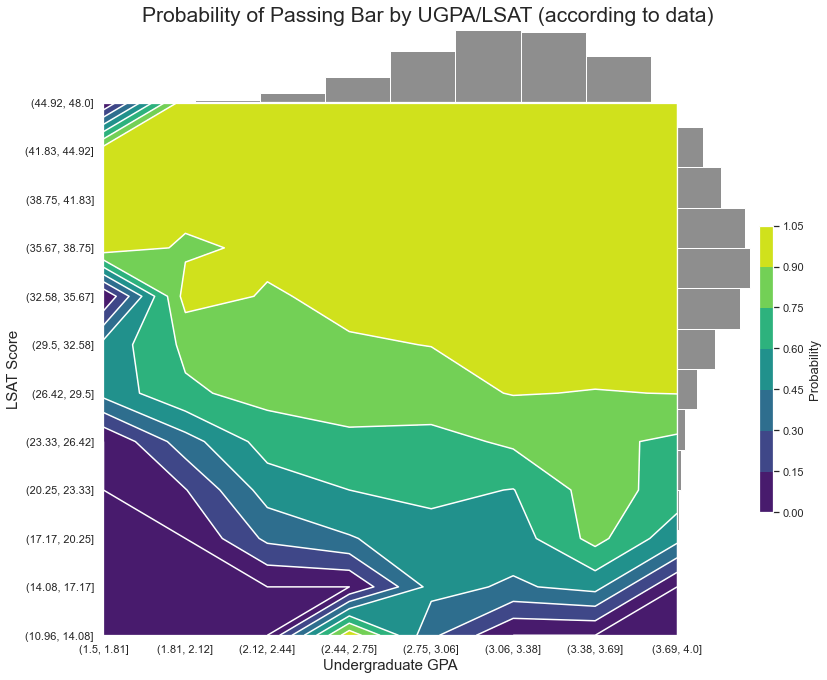

In [9]:
plot_prob_contour_map(law_df.ugpa, law_df.lsat, law_df.pass_bar, x_intervals=8, y_intervals=12,\
                      xlabel='Undergraduate GPA', ylabel='LSAT Score',\
                      title='Probability of Passing Bar by UGPA/LSAT (according to data)')

### 3.6) Train/Test Split

Split the data for modeling and initialize random seed:

In [10]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

y = law_df[target_col]
X = law_df[predict_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,\
                                                    random_state=rand)

## 4) Modeling & Interpretation

### 4.1) Evaluation Utility Method

This method helps easily evaluate the models:

In [11]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot_roc=True, plot_conf_matrix=False,\
                       pct_matrix=True):
    """Given a classification model, plots an ROC curve and outputs some predictive
    performance metrics. Then it returns the predictions.
    
    Keyword arguments:
    fitted_model -- a fitted classification model with a `predict` or `predict_proba` function
    X_train -- training features (pandas dataframe or array)
    X_test -- test features (pandas dataframe or array)
    y_train -- training labels (pandas dataframe or array)
    y_test -- test labels (pandas dataframe or array)
    plot_roc -- whether to display ROC plot or not (boolean)
    plot_conf_matrix -- whether to display confusion matrix or not (boolean)
    """
    
    sns.set()
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
        
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    if plot_roc:
        plt.figure(figsize = (12,12))
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
        plt.xlabel('False Positive Rate', fontsize = 14)
        plt.ylabel('True Positive Rate', fontsize = 14)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc="lower right")
        plt.show()
        
    if plot_conf_matrix: 
        cf_matrix = metrics.confusion_matrix(y_test,\
                                             y_test_pred)
        plt.figure(figsize=(6, 5))
        if pct_matrix:
            sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
                        fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            sns.heatmap(cf_matrix, annot=True,\
                        fmt='d',cmap='Blues', annot_kws={'size':16})
        plt.show()
        
    print('\tAccuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                        (metrics.accuracy_score(y_train, y_train_pred),\
                         metrics.accuracy_score(y_test, y_test_pred)))
    print('\tPrecision_test:  %.4f\t\tRecall_test:     %.4f' %\
                        (metrics.precision_score(y_test, y_test_pred),\
                         metrics.recall_score(y_test, y_test_pred)))
    print('\tROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                        (roc_auc,\
                         metrics.f1_score(y_test, y_test_pred),\
                         metrics.matthews_corrcoef(y_test, y_test_pred)))
    return y_train_pred, y_test_prob, y_test_pred

### 4.2) Train Model with LightGBM

A base un-tuned LightGBM classifier:

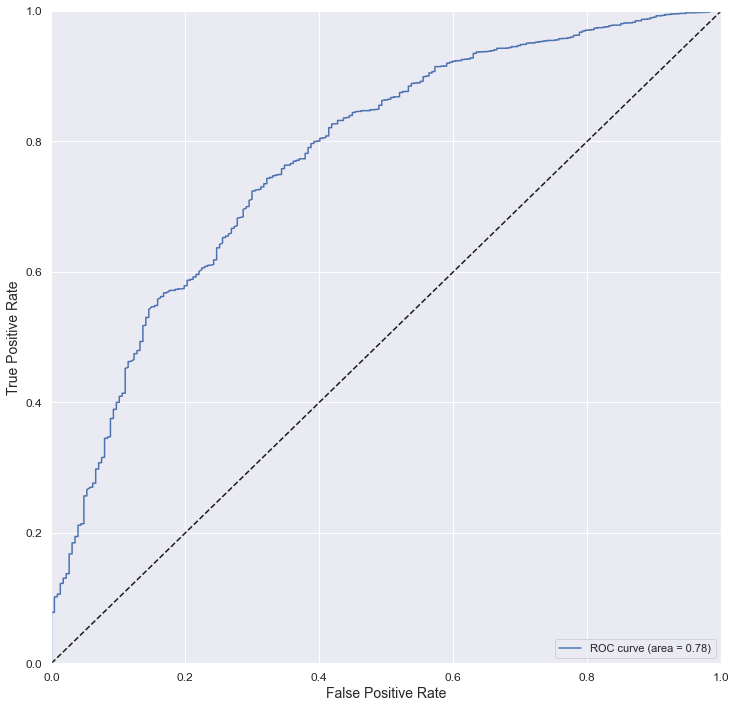

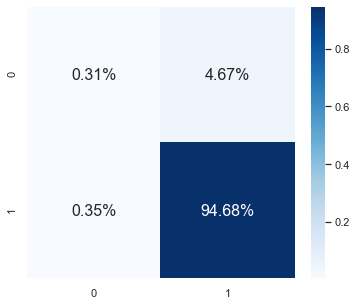

	Accuracy_train:  0.9550		Accuracy_test:   0.9498
	Precision_test:  0.9530		Recall_test:     0.9963
	ROC-AUC_test:    0.7756		F1_test:         0.9742		MCC_test: 0.1560


In [12]:
lgb_mdl = lgb.LGBMClassifier(random_seed=rand)
fitted_lgb_mdl = lgb_mdl.fit(X_train, y_train)
y_train_lgb_pred, y_test_lgb_prob, y_test_lgb_pred = evaluate_class_mdl(fitted_lgb_mdl, X_train,\
                                                                        X_test, y_train, y_test,\
                                                                        plot_conf_matrix=True)

### 4.3) Train Cost-sensitive Model with LightGBM

To acheive perfect class balance this is what should be `scale_pos_weight`:

In [13]:
print(y_train[y_train==0].shape[0]/y_train[y_train==1].shape[0])

0.054461449610164595


But by hyperparameter tuning you arrive that `scale_pos_weight=0.192` is the best value to maximize F1 score:

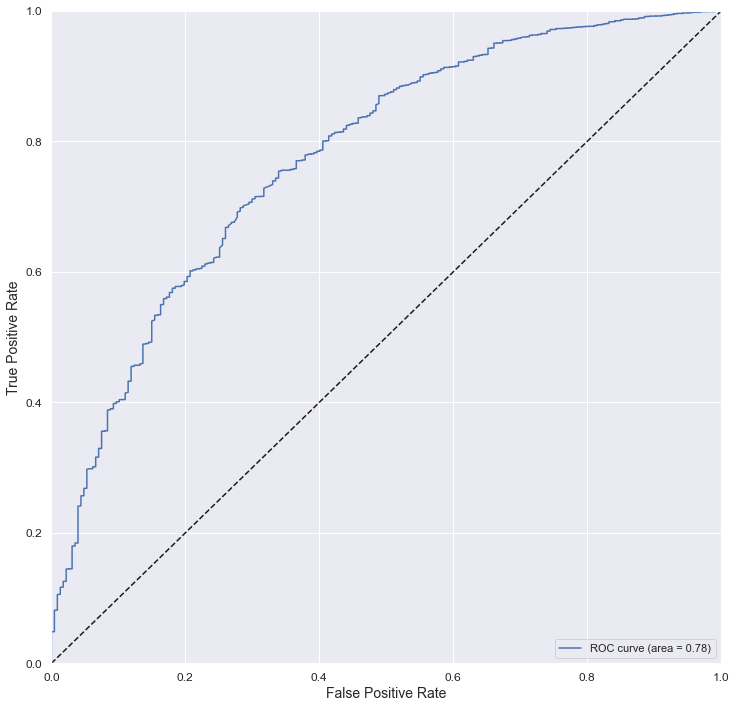

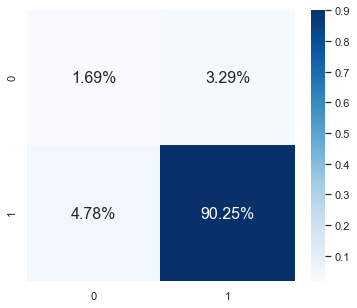

	Accuracy_train:  0.9402		Accuracy_test:   0.9194
	Precision_test:  0.9649		Recall_test:     0.9497
	ROC-AUC_test:    0.7760		F1_test:         0.9572		MCC_test: 0.2555


In [14]:
lgb_mdl = lgb.LGBMClassifier(random_seed=rand, scale_pos_weight=0.192)
fitted_lgb_mdl = lgb_mdl.fit(X_train, y_train)
y_train_lgb_pred, y_test_lgb_prob, y_test_lgb_pred = evaluate_class_mdl(fitted_lgb_mdl, X_train,\
                                                                        X_test, y_train, y_test,\
                                                                        plot_conf_matrix=True)

### 4.4) Interpret Cost-sensitive LightGBM model with SHAP Values

To obtain importances of features and an idea of which feature values correlate the most with passing the bar:

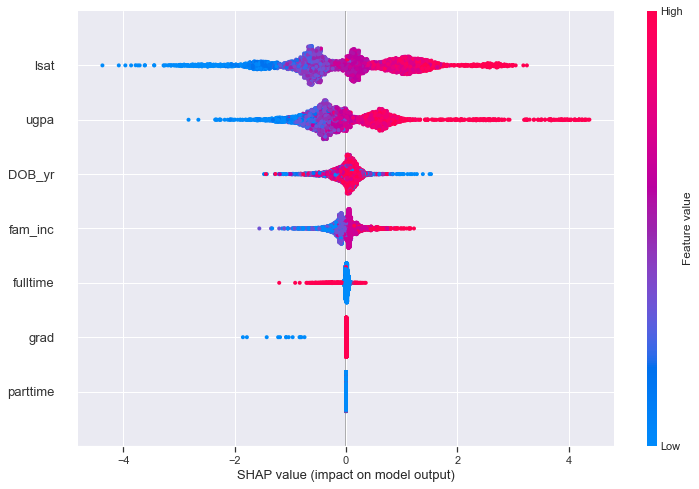

In [15]:
shap_lgb_explainer = shap.TreeExplainer(fitted_lgb_mdl)
shap_lgb_vals = shap_lgb_explainer.shap_values(X_test)
shap.summary_plot(shap_lgb_vals[1], X_test, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

### 4.5) Interpret Cost-sensitive LightGBM model with SHAP Interaction Values

You can produce a summary plot for interaction values as well but it's hard to interpret:

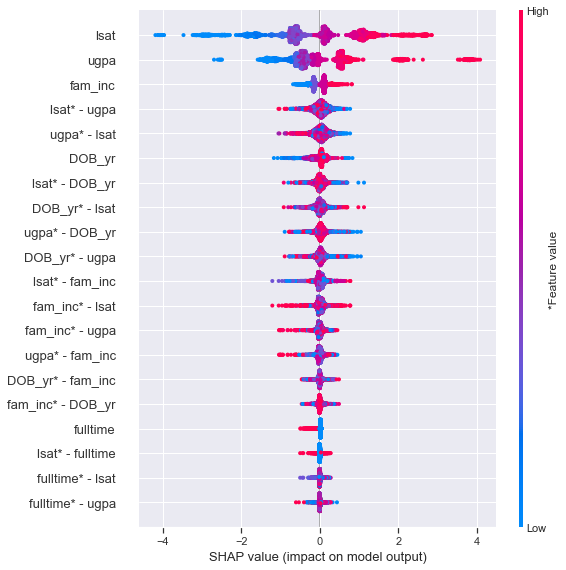

In [16]:
shap_lgb_interact_values = shap_lgb_explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_lgb_interact_values, X_test, plot_type="compact_dot", sort=True)

It's better to make a heat map with the interaction values like this:

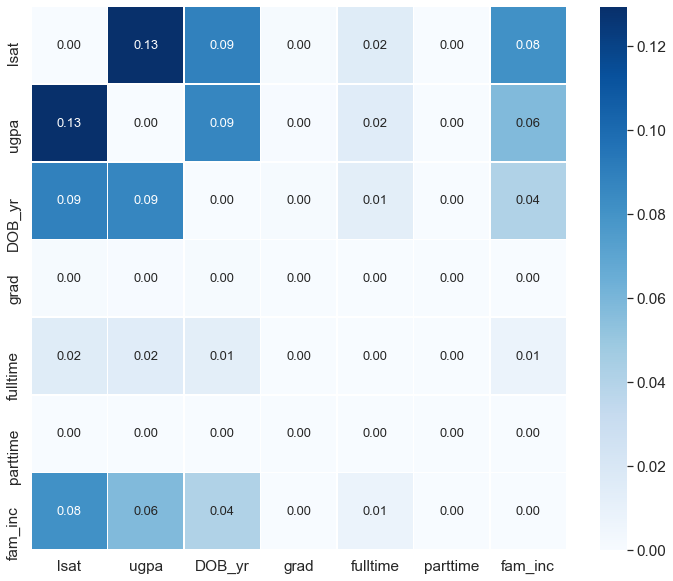

In [17]:
shap_lgb_interact_avgs = np.abs(shap_lgb_interact_values).mean(0)
np.fill_diagonal(shap_lgb_interact_avgs, 0)
shap_lgb_interact_df = pd.DataFrame(shap_lgb_interact_avgs)
shap_lgb_interact_df.columns = X_test.columns
shap_lgb_interact_df.index = X_test.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_lgb_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':13}, fmt='.2f', linewidths=.5)
plt.show()

### 4.6) Create a Contour Plot for the Cost-sensitive LightGBM model

Plot contour plot like that one done in `3.5` but for the model's labels, not the data's labels:

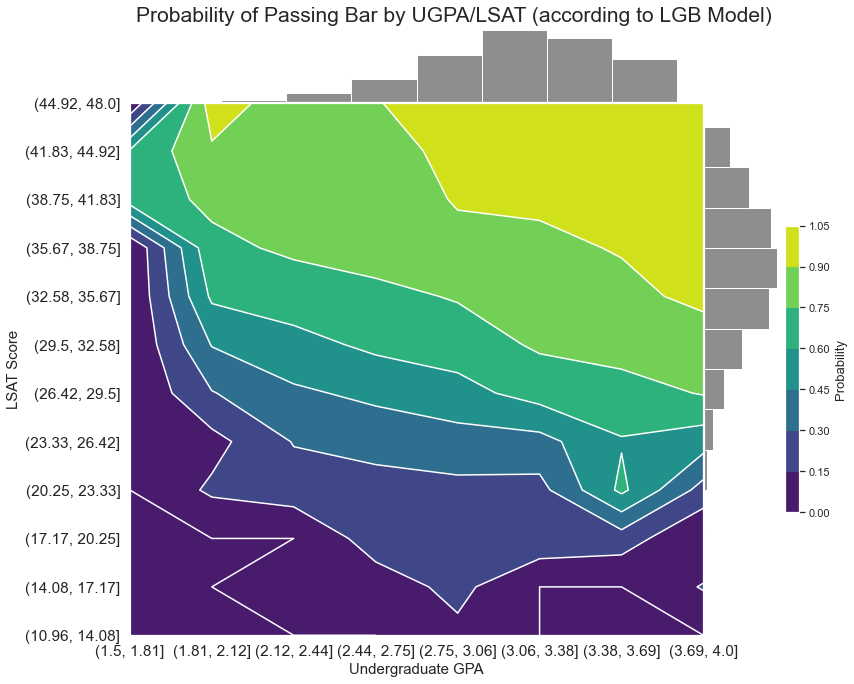

In [19]:
plot_prob_contour_map(law_df.ugpa, law_df.lsat, law_df.pass_bar, x_intervals=8, y_intervals=12,\
                      xlabel='Undergraduate GPA', ylabel='LSAT Score', X_df=X_test, x_col='ugpa',\
                      y_col='lsat', model=fitted_lgb_mdl, title='Probability of Passing Bar by UGPA/LSAT (according to LGB Model)')

### 4.7) Train Constrained Model with LightGBM

Set variables `mono_con` and `interact_con` for monotonic and interaction constraints respectively:

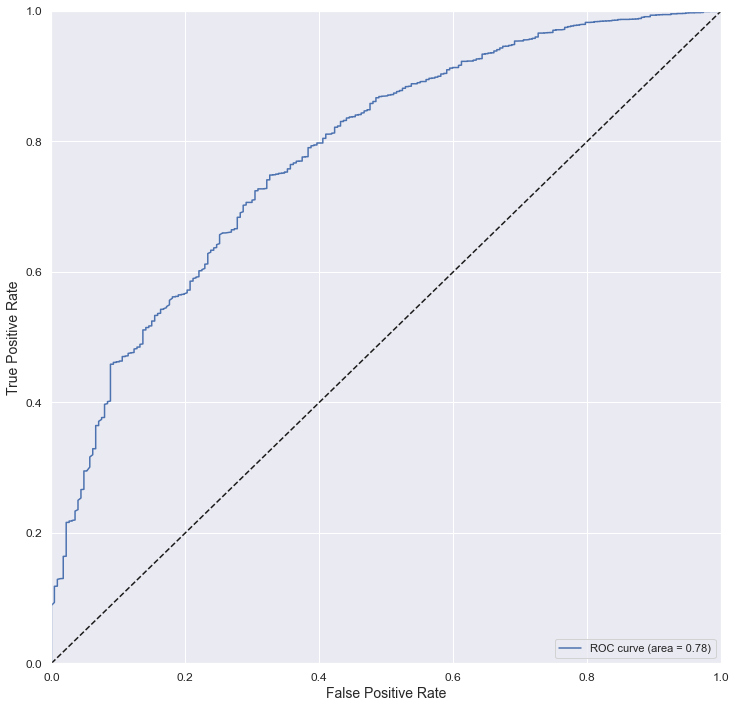

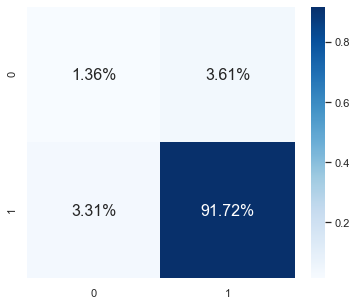

	Accuracy_train:  0.9374		Accuracy_test:   0.9308
	Precision_test:  0.9621		Recall_test:     0.9652
	ROC-AUC_test:    0.7814		F1_test:         0.9636		MCC_test: 0.2456


In [20]:
mono_con = (1,1,0,0,0,0,0)
interact_con = [[0, 1],[2, 3, 4, 5, 6]]

lgb_mono_mdl = lgb.LGBMClassifier(random_seed=rand, scale_pos_weight=0.267, monotone_constraints=mono_con,\
                                  interaction_constraints=interact_con)
fitted_lgb_mono_mdl = lgb_mono_mdl.fit(X_train, y_train)
sns.set()
y_train_lgb_mono_pred, y_test_lgb_mono_prob, y_test_lgb_mono_pred = evaluate_class_mdl(fitted_lgb_mono_mdl,\
                                                                                       X_train, X_test, y_train,\
                                                                                       y_test, plot_conf_matrix=True)

### 4.8) Interpret Constrained LightGBM model with SHAP Values

First, the SHAP `summary_plot` for SHAP values:

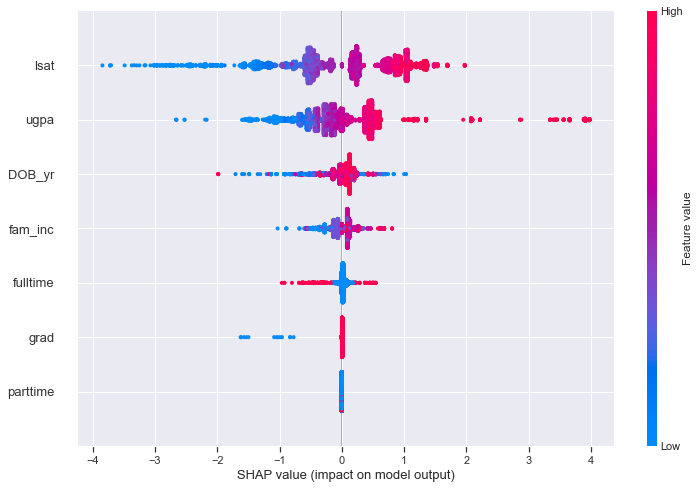

In [21]:
shap_lgb_mono_explainer = shap.TreeExplainer(fitted_lgb_mono_mdl)
shap_lgb_mono_vals = shap_lgb_mono_explainer.shap_values(X_test)
shap.summary_plot(shap_lgb_mono_vals[1], X_test, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

When compared with `4.4`, it is clear that monotonic constraints had the desired effect because first two features are smooth color gradients.

Second, the SHAP `summary_plot` for SHAP interaction values:

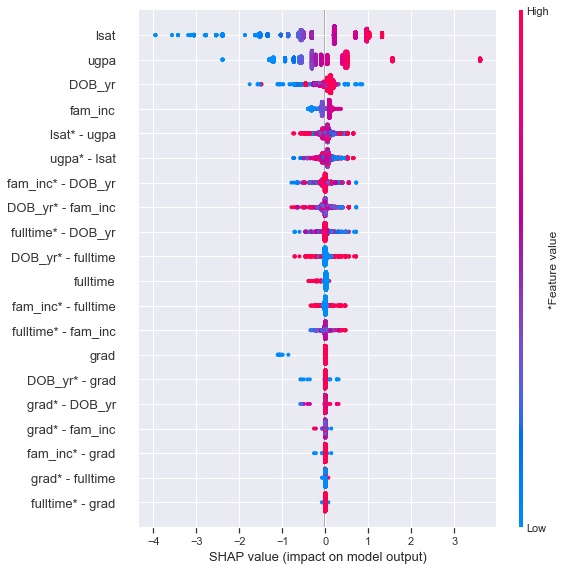

In [22]:
shap_lgb_mono_interact_values = shap_lgb_mono_explainer.shap_interaction_values(X_test)
shap.summary_plot(shap_lgb_mono_interact_values, X_test, plot_type="compact_dot", sort=True)

Third, the heat map with the interaction values:

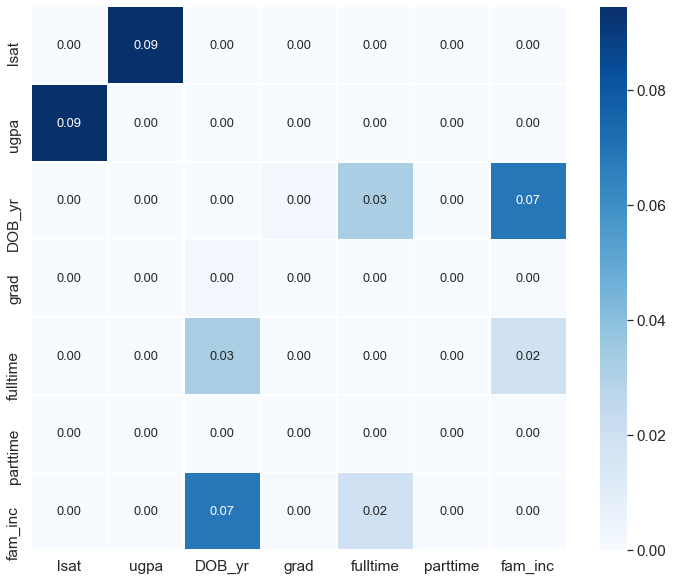

In [23]:
shap_lgb_mono_interact_avgs = np.abs(shap_lgb_mono_interact_values).mean(0)
np.fill_diagonal(shap_lgb_mono_interact_avgs, 0)
shap_lgb_mono_interact_df = pd.DataFrame(shap_lgb_mono_interact_avgs)
shap_lgb_mono_interact_df.columns = X_test.columns
shap_lgb_mono_interact_df.index = X_test.columns

plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(shap_lgb_mono_interact_df, cmap='Blues', annot=True,\
            annot_kws={'size':13}, fmt='.2f', linewidths=.5)
plt.show()

When compared with `4.5`, it is clear that interaction constraints had the desired effect.

### 4.9) Create a Contour Plot for the Constrained LightGBM model

Plot contour plot like that one done in `4.6` but for the constrained model:

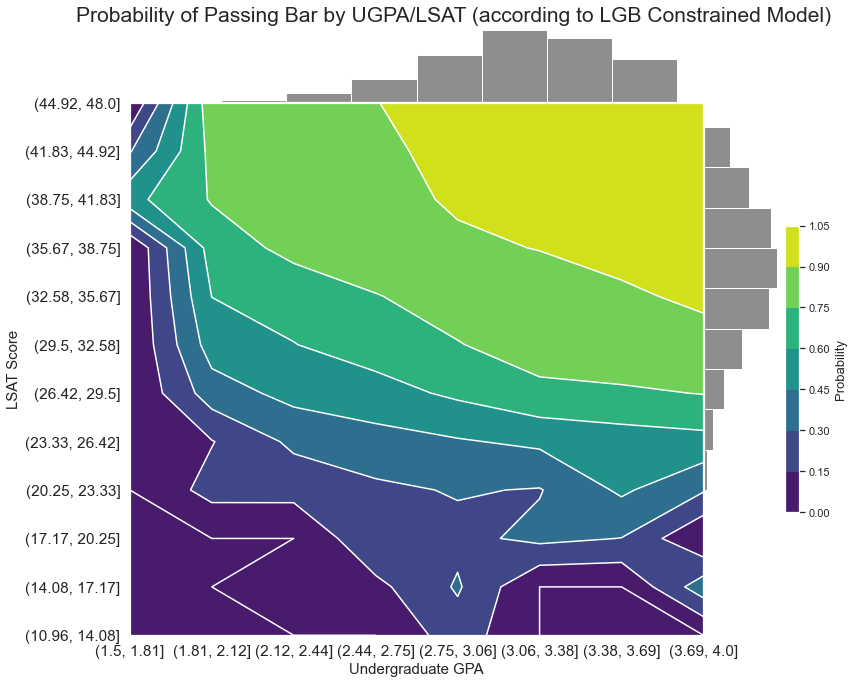

In [25]:
plot_prob_contour_map(law_df.ugpa, law_df.lsat, law_df.pass_bar, x_intervals=8, y_intervals=12,\
                      xlabel='Undergraduate GPA', ylabel='LSAT Score', X_df=X_test, x_col='ugpa',\
                      y_col='lsat', model=fitted_lgb_mono_mdl,\
                      title='Probability of Passing Bar by UGPA/LSAT (according to LGB Constrained Model)')

When compared with `4.6`, it is clear how much smoother.

### 4.10) Data Preparations for Tensorflow Lattice Model

In [26]:
NUM_EPOCHS = 1000

train_df = X_train.join(y_train)
test_df = X_test.join(y_test)

### 4.11) Functions for Tensorflow Lattice Model

Define input function:

In [27]:
def input_fn(input_df, num_epochs=1, batch_size=1000):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(
                x=input_df[['ugpa', 'lsat']], y=input_df['pass_bar'],\
                num_epochs=num_epochs, batch_size=batch_size, shuffle=False)

Define train function:

In [28]:
def train_fn(train_df, monotonicity=0, lr=0.0001):
    
    tfl_feature_columns = [
      tf.feature_column.numeric_column('ugpa'),
      tf.feature_column.numeric_column('lsat'),
    ]
    
    tfl_feature_configs = [
      tfl.configs.FeatureConfig(
          name='ugpa',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='lsat',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
    ]

    tfl_mdl_config = tfl.configs.CalibratedLinearConfig(
      feature_configs=tfl_feature_configs, use_bias=False)

    tfl_mdl = tfl.estimators.CannedClassifier(
      feature_columns=tfl_feature_columns,
      model_config=tfl_mdl_config,
      feature_analysis_input_fn=input_fn(train_df, num_epochs=1),
      optimizer=tf.keras.optimizers.Adam(lr))

    tfl_mdl.train(input_fn=input_fn(train_df, num_epochs=NUM_EPOCHS))
    
    return tfl_mdl

class tfl_model_wrapper:
    estimator = None
    input_fn = None
    
    def __init__(self, estimator, input_fn):
        self.estimator = estimator
        self.input_fn = input_fn
        
    def predict(self, input_df):
        predictions = self.estimator.predict(input_fn=self.input_fn(input_df=input_df, num_epochs=1))
        return np.array([prediction['probabilities'][1] for prediction in predictions])

### 4.11) Train Constrained Tensorflow Lattice Model

Train constrained model with train function and place in wrapper (`tfl_model_wrapper`) so that `predict` function can be compatible to any model evaluation function:

In [29]:
tfl_mono_mdl = train_fn(train_df, monotonicity=1)
wrapped_tfl_mono_mdl = tfl_model_wrapper(tfl_mono_mdl, input_fn)

Evaluate the constrained TF Lattice model:

In [30]:
y_train_tfl_mono_pred, y_test_tfl_mono_prob, y_test_tfl_mono_pred = evaluate_class_mdl(wrapped_tfl_mono_mdl,\
                                                                                       train_df, test_df, y_train,\
                                                                                       y_test, plot_roc=False)

	Accuracy_train:  0.9490		Accuracy_test:   0.9512
	Precision_test:  0.9525		Recall_test:     0.9984
	ROC-AUC_test:    0.7802		F1_test:         0.9749		MCC_test: 0.1625


### 4.12) Create a Contour Plot for the Constrained TF Lattice model

Plot contour plot like that one done in `4.9` but for TF Lattice model:

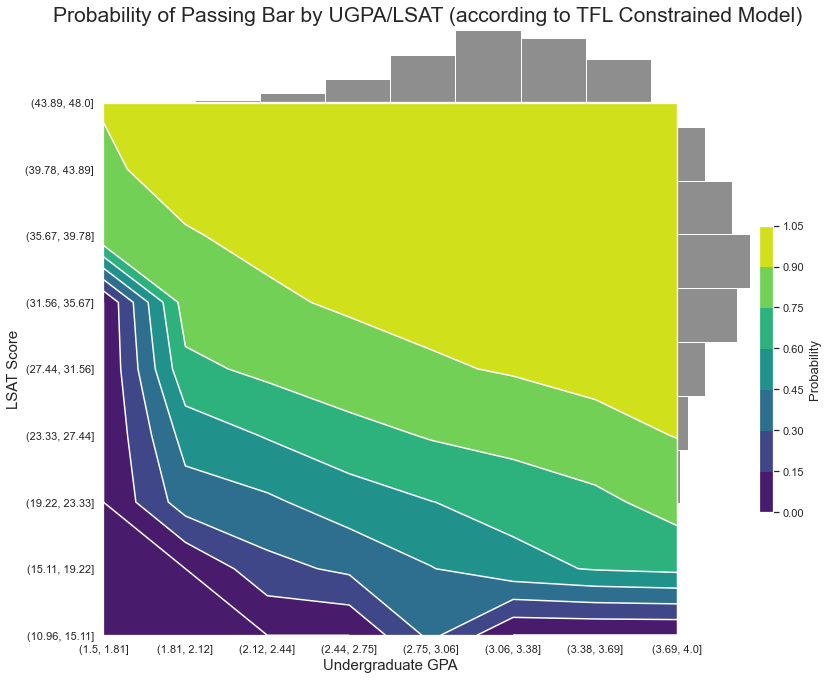

In [32]:
plot_prob_contour_map(law_df.ugpa, law_df.lsat, law_df.pass_bar, x_intervals=8, y_intervals=9,\
                      xlabel='Undergraduate GPA', ylabel='LSAT Score', X_df=test_df, x_col='ugpa',\
                      y_col='lsat', model=wrapped_tfl_mono_mdl,\
                      title='Probability of Passing Bar by UGPA/LSAT (according to TFL Constrained Model)')

## 5) Learn More 

### 5.1) Relevant External Documentation

- [LightGBM: Constraints](https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=monotone_constraints#core-parameters)
- [Tensorflow Lattice](https://www.tensorflow.org/lattice)
- [SHAP Github](https://github.com/slundberg/shap)

### 5.2) Other Python Code Examples

- [LightGBM Constraints: Analytics Vidhya](https://medium.com/analytics-vidhya/application-of-monotonic-constraints-in-machine-learning-models-334564bea616)
- [LightGBM Constraints: Towards Data Science](https://towardsdatascience.com/how-does-the-popular-xgboost-and-lightgbm-algorithms-enforce-monotonic-constraint-cf8fce797acb)
- [ODSC West Recidivism Fairness Example](https://serg.ai/odsc2020/) ~ Constraints in Catboost model

### 5.3) Interpretable ML Books / Blogs

- [Masis, Serg. (2021). Interpretable Machine Learning with Python: Learn to build interpretable high-performance models with hands-on real-world examples](https://www.amazon.com/gp/product/B08PDFXXRL/ref=dbs_a_def_rwt_hsch_vapi_taft_p1_i0) ~ Book with code examples in Python
- [Samek, Wojciech et al. (2019). Explainable AI: Interpreting, Explaining and Visualizing Deep Learning, Springer](https://www.springer.com/gp/book/9783030289539) ~ Book with no code examples
- [Sarkar, DJ. (2018). Explainable AI. Towards Data Science](https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476) ~ Blog thread with python code examples
- [Molnar, Christoph. (2019). Interpretable machine learning. A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/) ~ Book with code examples in R

### 5.4) Relevant Theory to this Session

- [Hastie, T. J., R. J. Tibshirani, and J. H. Friedman. (2001). The elements of statistical learning. Springer-Verlag, New York, New York, USA](https://www.amazon.com/Elements-Statistical-Learning-Prediction-Statistics/dp/0387848576)
- [Wang, S., & Gupta, M. (2020). Deontological Ethics By Monotonicity Shape Constraints. AISTATS.](https://arxiv.org/abs/2001.11990)
- [Cotter, A., Gupta, M., Jiang, H., Ilan, E.L., Muller, J., Narayan, T., Wang, S., & Zhu, T. (2019). Shape Constraints for Set Functions. ICML.](http://proceedings.mlr.press/v97/cotter19a.html)
- [Gupta, M. R., Bahri, D., Cotter, A., and Canini, K. (2018). Diminishing returns shape constraints for interpretability and regularization. Advances in Neural Information Processing Systems (NIPS).](https://papers.nips.cc/paper/2018/hash/caa202034f268232c26fac9435f54e15-Abstract.html)
- [Gupta, M. R., Cotter A., Pfeifer, J., Voevodski, K., Canini, K., Mangylov, A., Moczydlowski, W. and van Esbroeck, A. (2016). Monotonic Calibrated Interpolated Look-Up Tables. Journal of Machine Learning Research. 17(109):1−47.](https://arxiv.org/abs/1505.06378)
- [Lundberg, S., & Lee, S. (2017). A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems, 30.](https://arxiv.org/abs/1705.0787)
- [Štrumbelj, E., & Kononenko, I. (2014). Explaining prediction models and individual predictions with feature contributions. Knowledge and Information Systems, 41, 647-665.](https://doi.org/10.1007/s10115-013-0679-x)
- [Lipovetsky, S., & Conklin, M. (2001). Analysis of regression in game theory approach. Applied Stochastic Models in Business and Industry, 17.4, 319-330.](https://doi.org/10.1002/asmb.446)
- [Shapley, Lloyd S. (1953). "A Value for n-person Games". In Kuhn, H. W.; Tucker, A. W. (eds.). Contributions to the Theory of Games. Annals of Mathematical Studies. 28. Princeton University Press. pp. 307–317.](https://doi.org/10.1515/9781400881970-018)